<a href="https://colab.research.google.com/github/kushv16/Audio-Sentiment-Analysis/blob/master/Support_Vector_Machine_w_o_Crema.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('/content/drive/MyDrive/LY Project/combo.csv')

df['emotion'].replace({'angry':0,'disgust':1,'fear':2,'happy':3,'neutral':4,'sad':5,'surprise':6}, inplace=True)
df['gender'].replace({'female':0,'male':1}, inplace=True)


df.dropna(inplace = True)
df.drop(df[df['dataset'] == 'CREMA-D'].index, inplace = True)

X = df.drop(columns=['path','filename','dataset','duration','age','emotion'])
y = df.emotion.values

In [3]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=0.9, shuffle=True, stratify=y, random_state=0)

print('Shape of x_tr: ', X_tr.shape)
print('Shape of y_tr: ', y_tr.shape)
print('Shape of x_te: ', X_te.shape)
print('Shape of y_te: ', y_te.shape)

Shape of x_tr:  (8407, 91)
Shape of y_tr:  (8407,)
Shape of x_te:  (935, 91)
Shape of y_te:  (935,)


In [4]:
# Scale the data
from sklearn.preprocessing import StandardScaler

# Create Standard scaler
scaler = StandardScaler()

# Rescale data
X_tr_rescaled = scaler.fit_transform(X_tr)
X_te_rescaled = scaler.transform(X_te)

In [5]:
%%time

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

rbf_svc = SVC(class_weight="balanced", random_state=0)

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

param_grid = {
     "kernel": ["rbf"],
     "gamma": np.logspace(-4,4,num=9),  
     "C": np.logspace(-4,4,num=9)       
    }

# Instantiate the grid search model
grid_cv = GridSearchCV(estimator = SVC(), param_grid = param_grid, cv = kfold, n_jobs = -1, return_train_score=1)

# Fit estimator
grid_cv.fit(X_tr_rescaled,y_tr)

CPU times: user 25.6 s, sys: 2.61 s, total: 28.3 s
Wall time: 1h 8min 56s


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04]),
                         'gamma': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04]),
                         'kernel': ['rbf']},
             return_train_score=1)

In [9]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_cv.cv_results_)

cols = [
    'mean_test_score',
    'param_C',
    'param_gamma',
]

# Display fist 10 columns with higher mean validation score
cv_results[cols].sort_values(by="mean_test_score", ascending=False).head()

,mean_test_score,param_C,param_gamma
65,0.940049,1000.0,0.01
74,0.940049,10000.0,0.01
56,0.940049,100.0,0.01
47,0.938859,10.0,0.01
64,0.917329,1000.0,0.001


In [12]:
best_result = cv_results.sort_values(by="mean_test_score", ascending=False).head(1)

best_result.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
65,2.276935,0.56918,0.959595,0.342739,1000.0,0.01,rbf,"{'C': 1000.0, 'gamma': 0.01, 'kernel': 'rbf'}",0.950654,0.935196,...,0.940049,0.006202,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [7]:
cv_results.to_csv("/content/drive/MyDrive/LY Project/svm_without_crema_grid_search.csv")

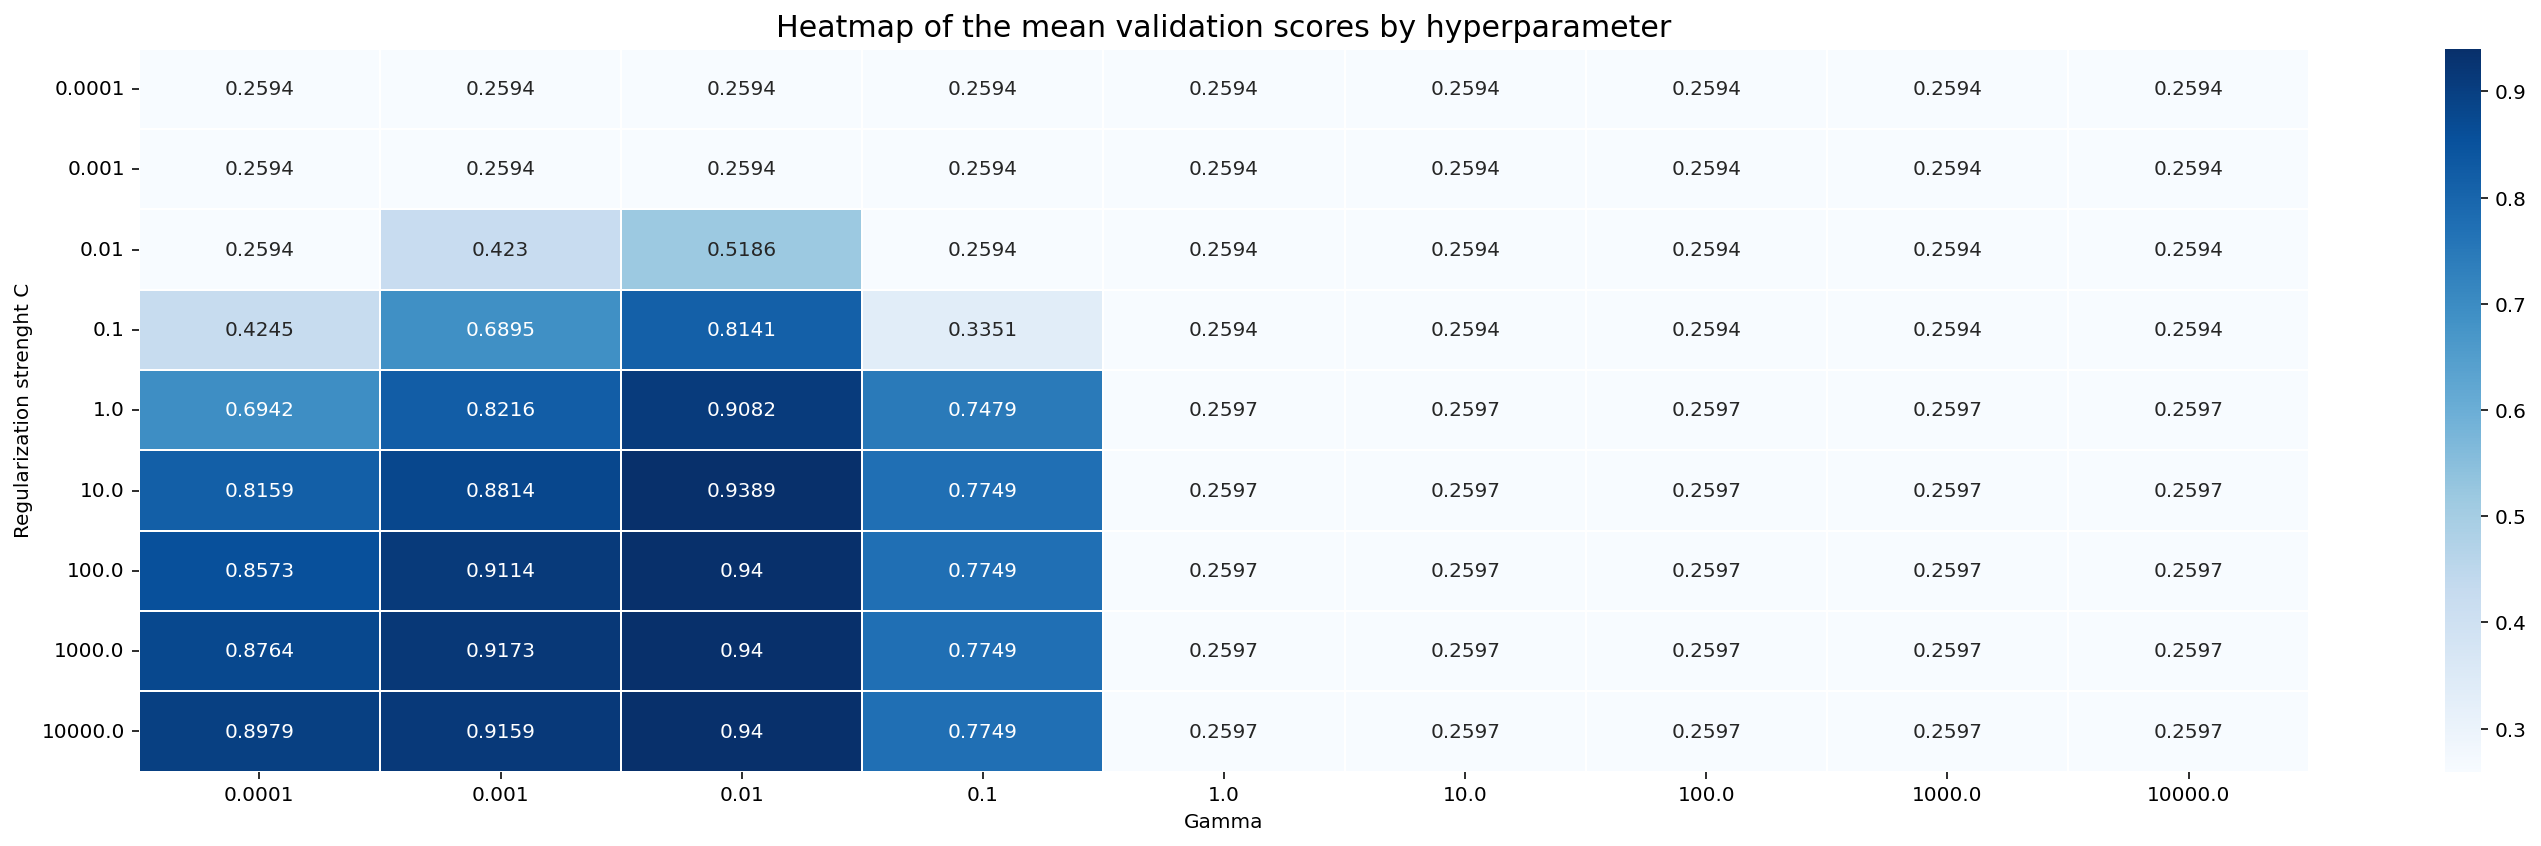

In [11]:
# Create DataFrame to host heatmap data
df_heatmap = cv_results[cols].pivot(index='param_C', columns='param_gamma', values='mean_test_score') 

# Plotting the results
plt.figure(figsize=(20,6))
sns.heatmap(df_heatmap, annot=True, linewidths=1, fmt=".4g", cmap="Blues")
plt.title('Heatmap of the mean validation scores by hyperparameter', size=15)
plt.xlabel('Gamma')
plt.ylabel('Regularization strenght C')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/LY Project/svm_without_crema_heatmap_by_hyperparameters.png')
plt.show()

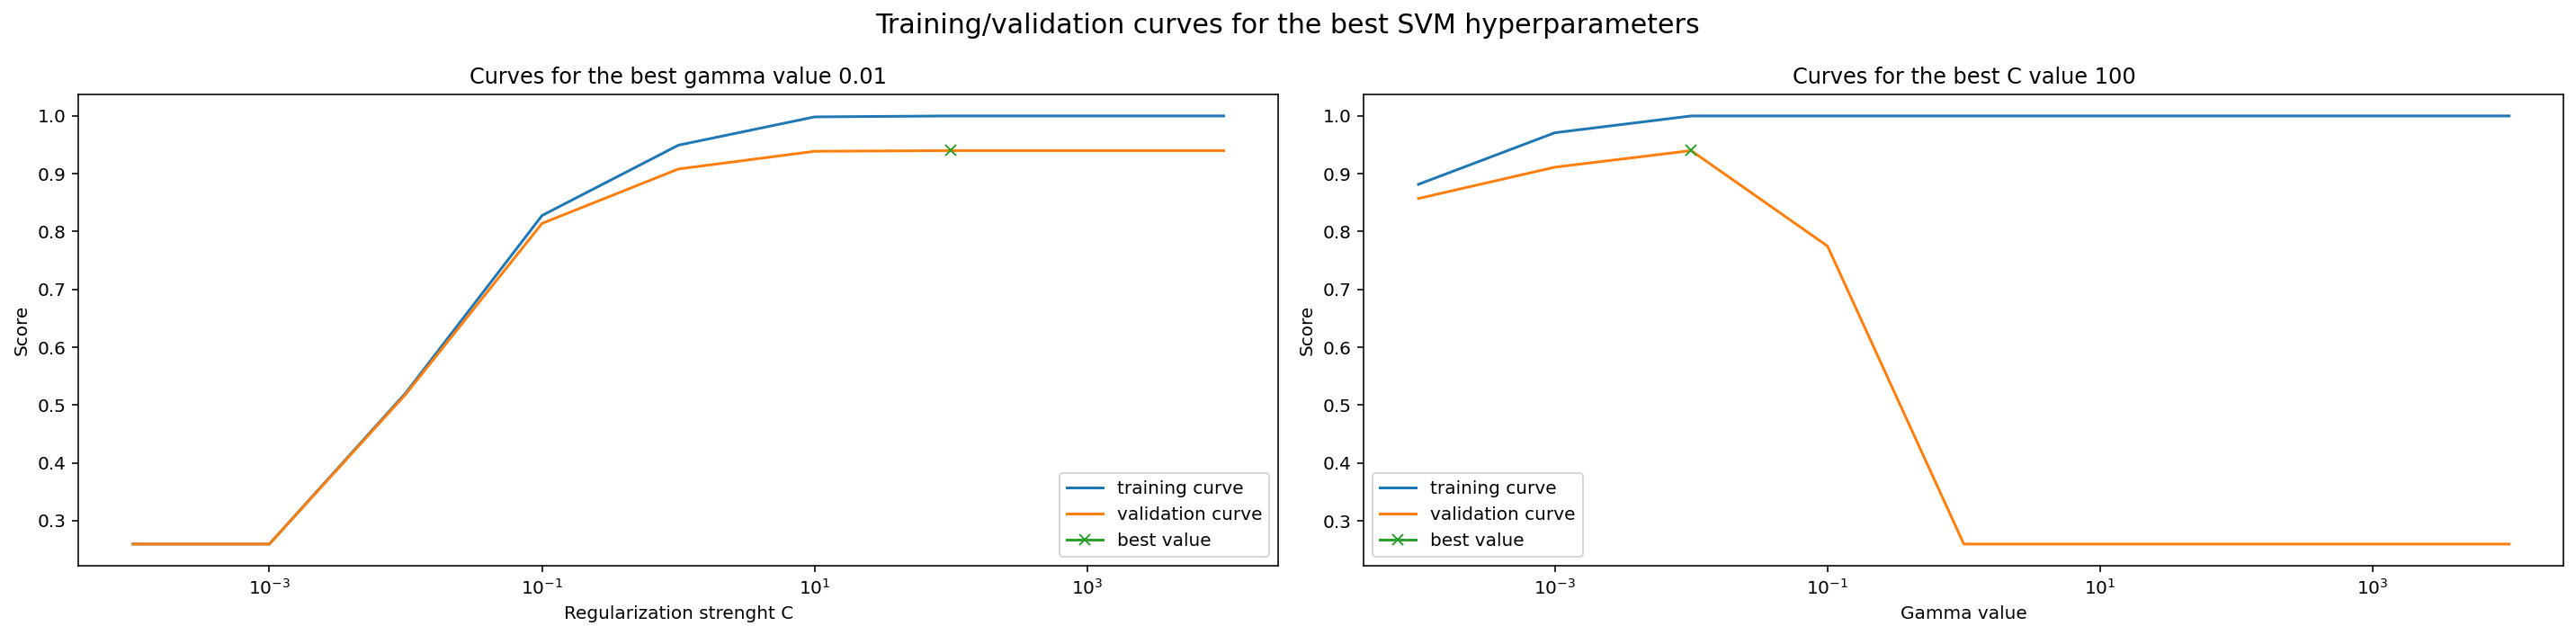

In [14]:
# Creates a figure with multiple subplot
fig, axs = plt.subplots(1, 2, figsize=(20, 5), sharey=False)

# Plot the training/validation curves
df_cv = cv_results[(cv_results["param_gamma"] == 0.01)]
axs[0].semilogx(df_cv["param_C"], df_cv["mean_train_score"], label="training curve")
axs[0].semilogx(df_cv["param_C"], df_cv["mean_test_score"], label="validation curve")
axs[0].plot(100, 0.9414, marker="x", label = "best value")
axs[0].set_xlabel('Regularization strenght C')
axs[0].set_ylabel('Score')
axs[0].set_title('Curves for the best gamma value 0.01')
axs[0].legend(loc="lower right")

df_cv = cv_results[(cv_results["param_C"] == 100)]
axs[1].semilogx(df_cv["param_gamma"], df_cv["mean_train_score"], label="training curve")
axs[1].semilogx(df_cv["param_gamma"], df_cv["mean_test_score"], label="validation curve")
axs[1].plot(0.01, 0.9414, marker="x", label = "best value")
axs[1].set_xlabel('Gamma value')
axs[1].set_ylabel('Score')
axs[1].set_title('Curves for the best C value 100')
axs[1].legend(loc="lower left")


plt.suptitle('Training/validation curves for the best SVM hyperparameters', size=15)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/LY Project/svm_without_crema_training_curves.png')

plt.show()

In [15]:
best_svm = SVC(kernel='rbf', C=100, gamma=0.01, probability=True)

best_svm.fit(X_tr_rescaled,y_tr)

print('Test accuracy of the SVC classifier with RBF kernel: {:.3f}'.format(best_svm.score(X_te_rescaled, y_te)))

Test accuracy of the SVC classifier with RBF kernel: 0.956


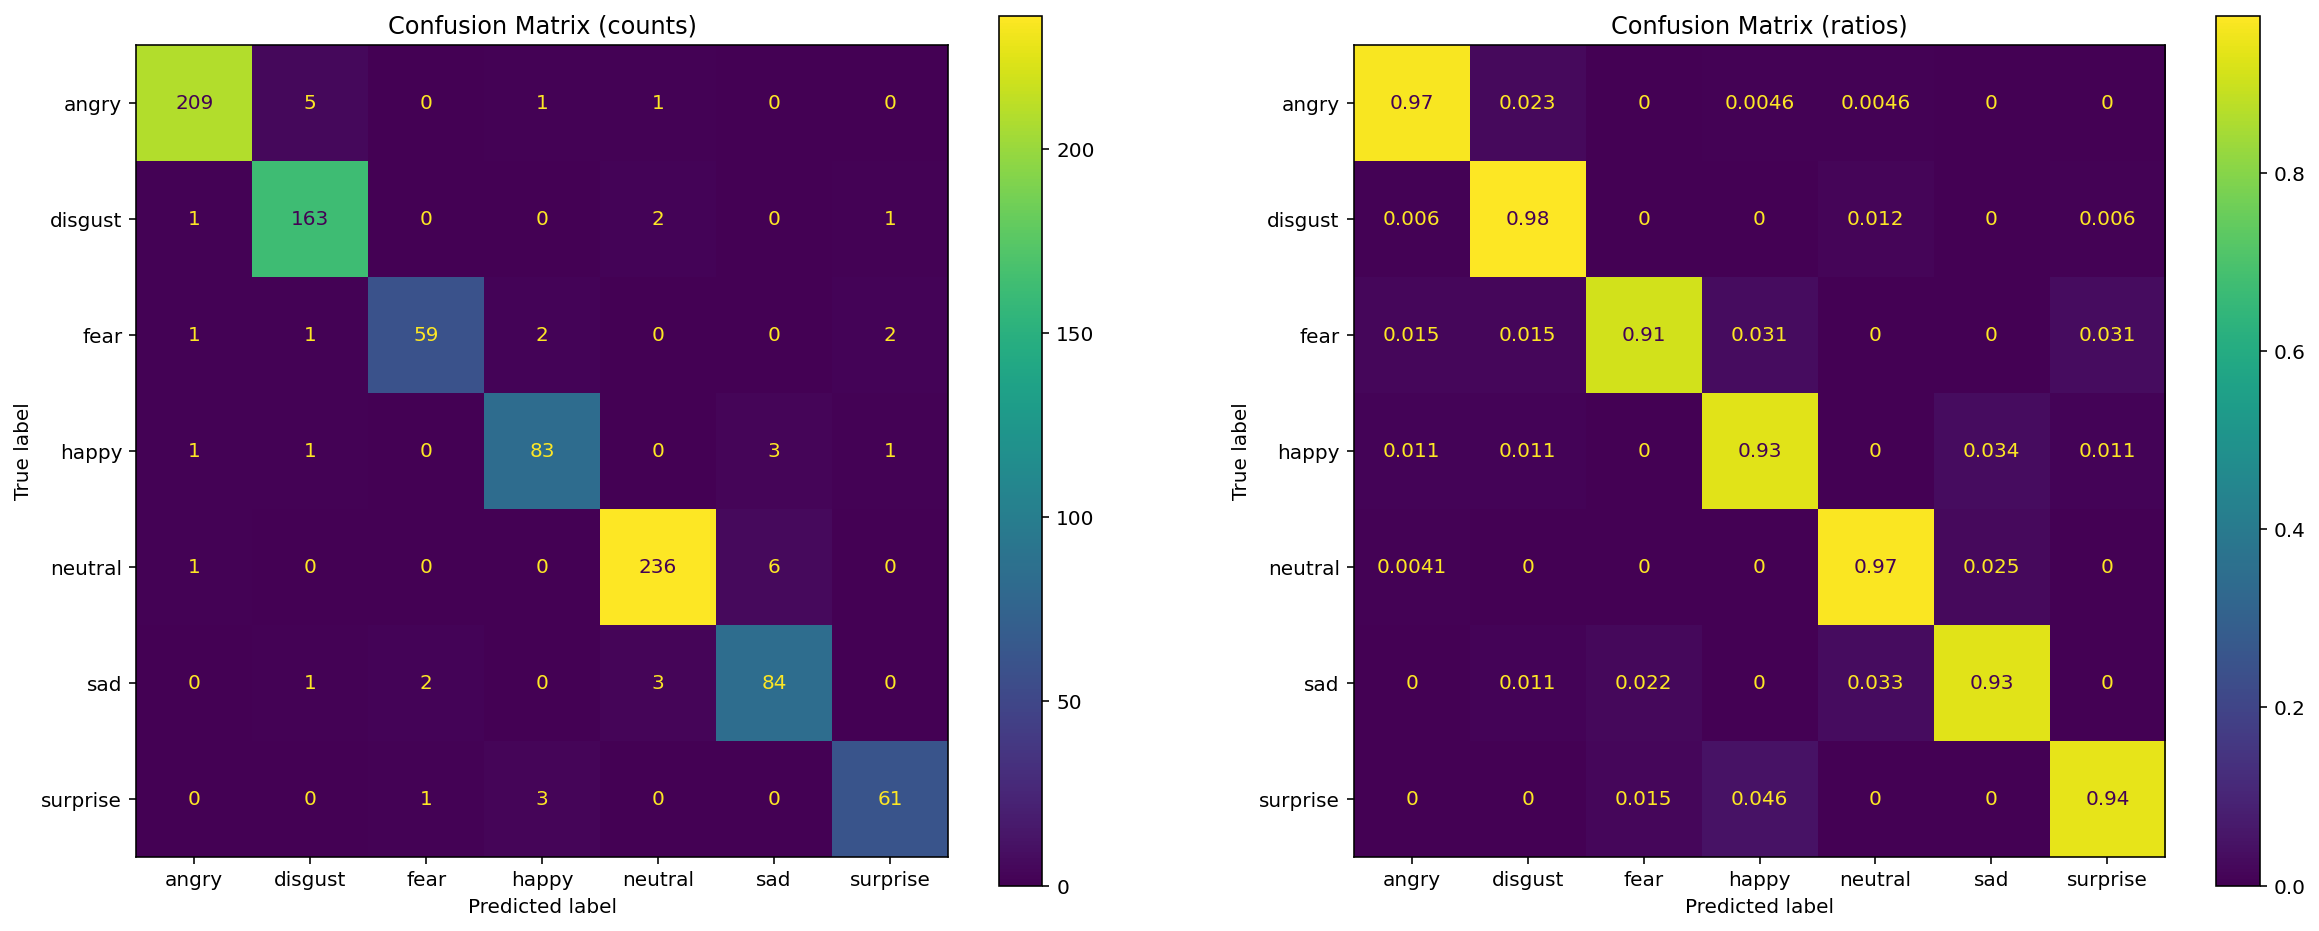

In [17]:
# Predicting the categories
y_probabilities = best_svm.predict_proba(X_te_rescaled)

predicted = []

for i in y_probabilities:
    predicted.append(np.argmax(i))
    
# Define confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

labels = {'angry':0,'disgust':1,'fear':2,'happy':3,'neutral':4,'sad':5,'surprise':6}

def plot_confusion_matrices(y_true, y_pred):

    # Create two subplots
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plots the standard confusion matrix
    ax1.set_title("Confusion Matrix (counts)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, ax=ax1)

    # Plots the normalized confusion matrix
    ax2.set_title("Confusion Matrix (ratios)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, normalize="true", ax=ax2)
    plt.savefig("/content/drive/MyDrive/LY Project/svm_without_crema_confusion_matrix.png")
    plt.show()

# Plot confusion matrices
plot_confusion_matrices(y_te, predicted)